# Analysis of books appearing on New York Times Weekly Bestseller List [2010 - 2018]

The NYT Combined Print and E-Book Fiction bestseller lists started in 2011-02-13. This project explores the books that appeared on these lists up to the current date (Jan 2018) and aims to answer the following questions:

1) Which books appeared most often ? 

2) Which authors made the most appearances?

3) Which authors have the most number of books on the list?

4) Is there a relationship between the number of books an author has on the list to his/her number of appearances and average rank?

5) What are some of the common themes seen in books on the list?

#### SOURCE
Information about weekly bestseller lists was obtained using the NYT API. Information on each book was extracted, including title, author, book description and rank on that week's list.

Pandas and numpy was used to analyze the data and matplotlib/seaborn to visualize trends explore relationships.

nltk, wordcloud were used to visualize the commonly occuring themes for books appearing in list.


In [ ]:
# Generates list of dates from 2010 - 2017 to get weekly bestseller lists from NYT API

from datetime import datetime
from datetime import timedelta

def set_date_range(start_date,end_date):
    
    date = start_date
   
    date_list = []
    while date <= end_date:    
        date_list.append(datetime.date(date).isoformat())
        date = date + timedelta(days=7)
        
    return date_list
   
start_date = datetime(2011,2,13)
end_date = datetime(2018,1,21)

date_list = set_date_range(start_date, end_date)

len(date_list)

In [ ]:
# Get data from NYT API
import requests
import unicodecsv as csv
from pprint import pprint
import sys
import time

# extracts data from json and writes to csv
def get_data_json(date, listname, filename):

    # get personal api key from NYT
    apikey = "XXX"
    url = "http://api.nytimes.com/svc/books/v2/lists/{}/{}.json?api-key={}".format(date,listname,apikey)

    resp = requests.get(url)
    
    if resp:
        contents = resp.json()
    
        booklist = contents['results']

        bookdetails = []
        for book in booklist:
            dct = {}
            dct['author'] = book['book_details'][0]['author']
            dct['amazon_url'] = book['book_details'][0]['amazon_product_url']
            dct['title'] = book['book_details'][0]['title']
            dct['isbn10'] = book['book_details'][0]['primary_isbn10']
            dct['isbn13'] = book['book_details'][0]['primary_isbn13']
            dct['rank'] = book['rank']
            dct['description'] = book['book_details'][0]['description']
            dct['weeks_on_list'] = book['weeks_on_list']
            dct['listname'] = book['list_name_encoded']
            dct['listpublisheddate'] = book['published_date']
            bookdetails.append(dct)

        f=open(filename,'a')
        csv_dict_writer = csv.DictWriter(f,fieldnames = header)
        csv_dict_writer.writerows(bookdetails)
        f.close()   

# specify types of bestseller lists to get info on
listnames= ["combined-print-and-e-book-fiction", 
            "combined-print-and-e-book-nonfiction"]


header = ['isbn10','isbn13','title','author','rank','weeks_on_list','amazon_url', 
              'listname','description', 'listpublisheddate']

def create_csv(filename,header):
    
    f = open(filename,'w')
    csv_dict_writer = csv.DictWriter(f,fieldnames = header)
    csv_dict_writer.writeheader()
    f.close()

# get data for specified listname and date
for listname in listnames:
    filename = "booklist_{}.csv".format(listname)
    create_csv(filename, header)
    for date in date_list:
        get_data_json(date,listname,filename)
        time.sleep(0.3)


In [ ]:
# Exploratory data analysis on collected data. 

import pandas as pd
import numpy as np

listnames= ["combined-print-and-e-book-fiction", 
            "combined-print-and-e-book-nonfiction"]
filename = "booklist_{}.csv".format(listnames[0])

df = pd.read_csv(filename)

print ("No. of records = %d" %(len(df)))

df['author'] = df['author'].apply(lambda x:x.lower())
df['title'] = df['title'].apply(lambda x:x.lower())
df['author-title'] = df['author'] + " - " + df['title']

## Lists ranged from top 15 lists to top 20 lists. for consistency, only consider the top15 for all lists
df.groupby('listpublisheddate')['isbn13'].count().min()
df = df[df['rank']<=15]

print ("No. of unique book titles = %d" %(len(df['author-title'].unique())))
print ("No. of authors = %d" %(len(df['author'].unique())))
print ("No. of unique book descriptions = %d" %(len(df['description'].unique())))
print ("No. of unique book isbns = %d" %(len(df['isbn13'].unique())))
print ("No. of entries missing book descriptions = %d" %(df['description'].isnull().sum()))

## cleaning required since unique descriptions do not match unique book titles or isbns

In [3]:
x = df.groupby('author-title')['isbn13'].apply(lambda x:len(x.unique())).sort_values(ascending = False)
multi_isbn = x[x.values > 1].index

# 205 books have multiple editions listed. will clean this later and unify all records to the most common isbn for each book title. this will allow for extraction of info from goodreads
len(multi_isbn)


205

In [4]:
### clean the book descriptions. use the longest description if there are discrepancies between the same book titles

def clean_desc(df): 
    
    descs = df['description'].unique()
    unified_desc = descs.max()
    df['description'] = unified_desc 
   
    return df

df_cleaned = df.groupby('author-title').apply(lambda x: clean_desc(x))

# There are a few books with missing descriptions
print ("No. of unique book titles= %d" %(len(df_cleaned['author-title'].unique())))
print ("No. of authors = %d" %(len(df_cleaned['author'].unique())))
print ("No. of unique book descriptions = %d" %(len(df_cleaned['description'].unique())))
print ("No. of unique book isbns = %d" %(len(df_cleaned['isbn13'].unique())))
print ("No. of entries missing book descriptions = %d" %(df_cleaned['description'].isnull().sum()))

# one of the descriptions seems to have escaped! will fix this later

No. of unique book titles= 1682
No. of authors = 546
No. of unique book descriptions = 1681
No. of unique book isbns = 1927
No. of entries missing book descriptions = 0


In [5]:
# get info on number of weeks that author/book appeared on list, as well as average rank of each author and book

num_authappear = df_cleaned['author'].value_counts().sort_values(ascending=True)
num_authappear.index = num_authappear.index.str.title()
num_bookappear = df_cleaned['author-title'].value_counts().sort_values(ascending=True)
num_bookappear.index = num_bookappear.index.str.title()
avg_bookrank = df_cleaned.groupby('author-title')['rank'].mean()
avg_authrank = df_cleaned.groupby('author')['rank'].mean()
num_bookappear2 = df_cleaned['title'].value_counts().sort_values(ascending=True)


/anaconda2/envs/pydot_p3_2/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


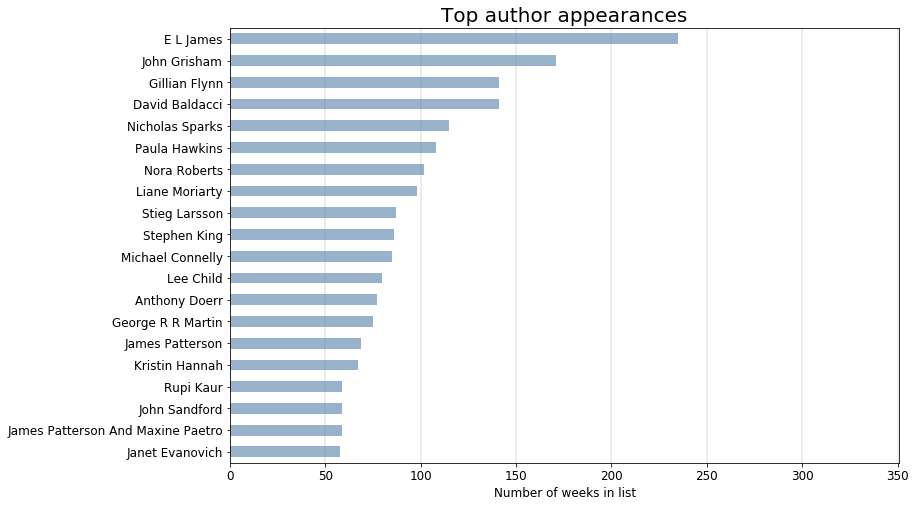

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns 

fig = plt.figure(figsize=(12,8))
fig = num_authappear.tail(20).plot.barh(color=(0.2, 0.4, 0.6, 0.5))


ax = plt.axes()
ax.grid(which='major', axis='x', color='gray', linestyle='-', linewidth=0.3)

ax.set_xlim(0,351) 
plt.xlabel("Number of weeks in list", fontsize = 12)
plt.title("Top author appearances", fontsize=20)

for label in ax.xaxis.get_ticklabels():
    label.set_fontsize(12)
for label in ax.yaxis.get_ticklabels():
    label.set_fontsize(12)

plt.show(fig)

ax.figure.savefig('topauthorappearances', bbox_inches = 'tight', dpi = 200)

/anaconda2/envs/pydot_p3_2/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


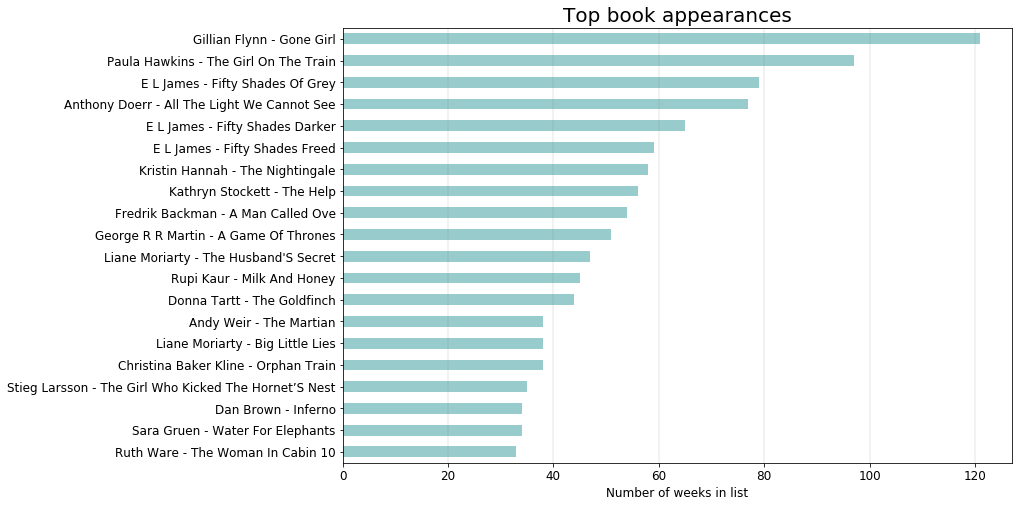

In [8]:
# visualize the books appearing most often. consider showing the average for all books
# to explore visualizing as a map and representing books using the book images in sizes corresponding to their frequency of appearance

import matplotlib.pyplot as plt
  

fig = plt.figure(figsize=(12,8))
fig = num_bookappear.tail(20).plot.barh(color=(0.2, 0.6, 0.6, 0.5))

ax = plt.axes()
ax.grid(which='major', axis='x', color='gray', linestyle='-', linewidth=0.2)

plt.xlabel("Number of weeks in list", fontsize = 12)
plt.title("Top book appearances", fontsize=20)
for label in ax.xaxis.get_ticklabels():
    label.set_fontsize(12)
for label in ax.yaxis.get_ticklabels():
    label.set_fontsize(12)

plt.show(fig)    
    
ax.figure.savefig('topbookappearances', bbox_inches = 'tight', dpi = 200)

##### Many of these books have movie tie-ins. Might be worth exploring the trending of their ranks over time and how this compares with the movie release date. 

/anaconda2/envs/pydot_p3_2/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


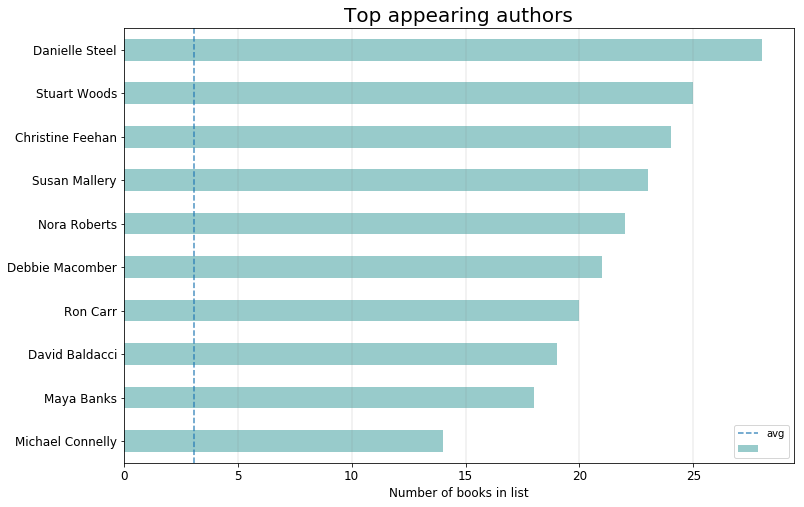

These authors, who make up 1% of all authors on the lists, contributed to 12% of books on the list


In [9]:
# visualize which authors has the most number of books on list

numbooksbyauthor= df_cleaned.groupby('author')['title'].apply(lambda x: len(x.unique()))
mostactiveauthors = numbooksbyauthor.sort_values(ascending = True).tail(10)
mostactiveauthors2 = numbooksbyauthor.sort_values(ascending = True).tail(10)
mostactiveauthors.index = mostactiveauthors.index.str.title()

fig = plt.figure(figsize=(12,8))
fig = mostactiveauthors.plot.barh(color=(0.2, 0.6, 0.6, 0.5))

ax = plt.axes()
ax.grid(which='major', axis='x', color='gray', linestyle='-', linewidth=0.2)

plt.xlabel("Number of books in list", fontsize=12)
ax.set_ylabel('', color = '#4e98ed')
plt.title("Top appearing authors", fontsize=20)
for label in ax.xaxis.get_ticklabels():
    label.set_fontsize(12)
for label in ax.yaxis.get_ticklabels():
    label.set_fontsize(12)

plt.axvline(numbooksbyauthor.mean(), linestyle='--', label = 'avg.', alpha = 0.8)
l = plt.legend()
ax.legend(labels= ['avg',''])

plt.show()

## 86 books contributed by 10 most active authors 
mostactiveauthors.values.sum()

### top 10 authors make up 2% of the 395 authors appearing on list
percentauth = 10*100/len(df_cleaned['author'].unique())
percentbooks = mostactiveauthors.values.sum()*100/len(df_cleaned['author-title'].unique())

ax.figure.savefig('topappearing.png', bbox_inches = 'tight', dpi = 200)

print("These authors, who make up %d%% of all authors on the lists, contributed to %d%% of books on the list"%(percentauth, percentbooks))


#### It might be interesting to see when these books were published (within a year of appearing on the list?). that's a lot of books by the same person over a 7-year period

In [10]:
# more data exploration on most active authors
authors = mostactiveauthors2.index
authorsubset = df_cleaned[df_cleaned['author'].isin(authors)]

num_titles = authorsubset.groupby('author')['title'].apply(lambda x: len(x.unique()))

avg_rank = authorsubset.groupby('author')['rank'].apply(lambda x: x.mean()).round(1)

authorsubset2 = pd.concat((num_titles,avg_rank), axis=1)

authorsubset2['author']=authorsubset2.index
authorsubset2.columns = ['num_titles','avgrank','author']
authorsubset2 = authorsubset2.sort_values('num_titles')


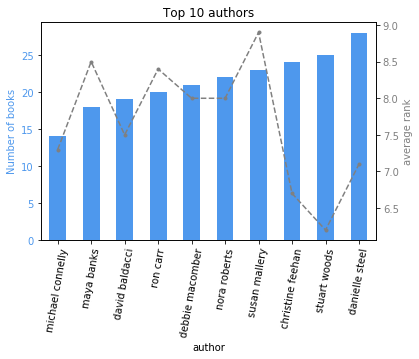

In [11]:
fig, ax = plt.subplots()

authorsubset2[['num_titles','author']].plot.bar(ax=ax , color = '#4e98ed', legend = False )
ax.set_ylabel('Number of books', color = '#4e98ed')
ax.set_xlabel('')
authorsubset2[['avgrank','author']].plot(ax=ax, secondary_y=True, style='.--', 
                                color='grey', legend = False)
ax.right_ax.set_ylabel('average rank', color = 'grey')


for tl in ax.get_yticklabels():
    tl.set_color('#4e98ed')

for label in ax.xaxis.get_ticklabels():
    label.set_rotation(80)

for tl in ax.right_ax.get_yticklabels():
    tl.set_color('grey')
    
plt.title("Top 10 authors")



plt.show()

ax.figure.savefig('top10.png', bbox_inches = 'tight', dpi = 200)

In [12]:
# explore relationship between number of books by an author, number of weeks author appeared on lists and average author rank

num_authappear = df_cleaned['author'].value_counts()
avg_rating = df_cleaned.groupby('author')['rank'].mean().round(1)
num_books_onlist = df_cleaned.groupby('author')['title'].apply(lambda x:len(x.unique()))

newdf = pd.concat((num_authappear,avg_rating,num_books_onlist), axis=1)
                  
newdf.columns = ['appearances','avgrank','numtitles']


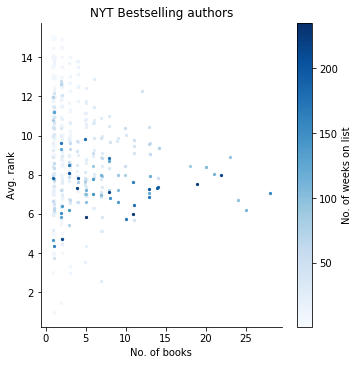

In [13]:
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors


g = plt.figure(figsize=(12,8))

g = sns.lmplot( x='numtitles', y='avgrank', data=newdf, fit_reg=False, hue ='appearances', 
                  legend = False, scatter_kws={"alpha":1,"s":5},
                  x_jitter=0.1,y_jitter=0.05 , palette='Blues')


normalize = mcolors.Normalize(vmin=newdf['appearances'].min(), 
                              vmax=newdf['appearances'].max())

colormap = cm.Blues

for n in newdf['appearances']:
    plt.plot(color=colormap(normalize(n)))

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(newdf['appearances'])
cbar = plt.colorbar(scalarmappaple)
cbar.ax.set_ylabel('No. of weeks on list')

plt.ylabel('Avg. rank')
plt.xlabel('No. of books')
plt.title("NYT Bestselling authors")

g.savefig('bestselling.png', bbox_inches = 'tight', dpi = 200)
plt.show()
#help(plt.savefig)

##### As expected, authors with fewer books tend to make fewer appearances on the list. (cluster towards 1st left quadrant)

##### Authors with more books do not necessarily perform better than those with less 


In [14]:
# explore common themes for books appearing on list based on word frequency analysis of book descriptions

#df_cleaned = df_cleaned.dropna(subset=['description'])
df_desc = df_cleaned['description'].unique()
text = ' '.join(desc for desc in df_desc)
text = text.lower()

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize import MWETokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
import nltk

mwetokenizer = MWETokenizer([('new', 'york'), ('new','hampshire'), ('los','angeles'),
                            ('new','book'),('new','orleans')],separator = ' ')

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None
    
word_tokens = word_tokenize(text)

word_tokens = mwetokenizer.tokenize(word_tokens)

tagged = nltk.pos_tag(word_tokens)
lemmatizer = WordNetLemmatizer()

dct = {}
stopw = set(stopwords.words("english")+["novel", "book", "trilogy", "series", "new", "must",
                                       "one","two", "story", "author", "writer"])

for word, tag in tagged:
    wntag = get_wordnet_pos(tag)
    #word = word.lower()
    #if word not in stopw:
    if wntag is None:# not supply tag in case of None
        lemma = lemmatizer.lemmatize(word) 
    else:
        lemma = lemmatizer.lemmatize(word, pos=wntag) 
   
    if ((len(word)>2) & ('\'' not in word)):
        if lemma not in stopw:
            dct[lemma]=dct.get(lemma,0) + 1
            


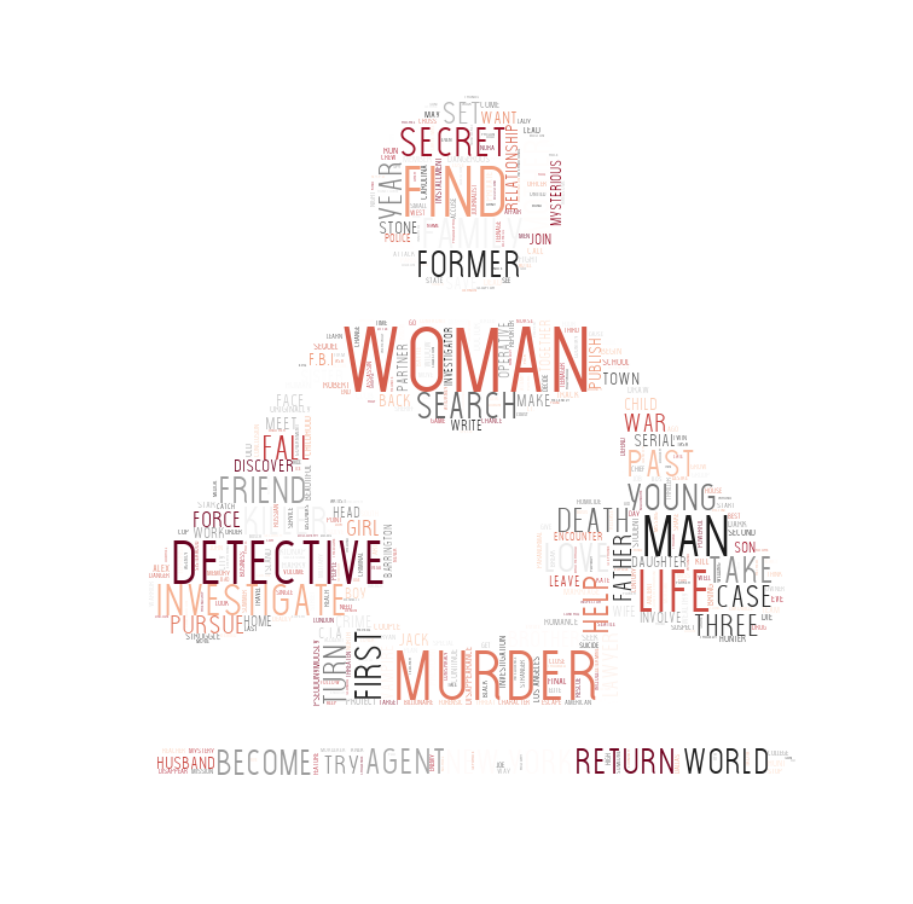

In [15]:
### need to do something about the color!
import random
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
#from palettable.colorbrewer.qualitative import Dark2_8
import matplotlib
import matplotlib.pyplot as plt


folder = ""
font_path = "TheLightFont.ttf"

imagefile = "read"

image_path = folder + "%s.png" % imagefile
icon = Image.open(image_path).convert("RGBA")

mask = Image.new("RGB", icon.size, (255,255,255))
mask.paste(icon,icon)
mask = np.array(mask)


wc = WordCloud(font_path = font_path, background_color="white", max_words=500, mask=mask,
               max_font_size=90, random_state=77, 
               colormap=matplotlib.cm.RdGy, width = 1200, height = 800)

wc.generate_from_frequencies(dct)

plt.figure(figsize=(24,16))

plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.savefig('fiction.png', bbox_inches='tight', dpi=600)
plt.show()
wc.to_file("NYTFiction-combined.png")

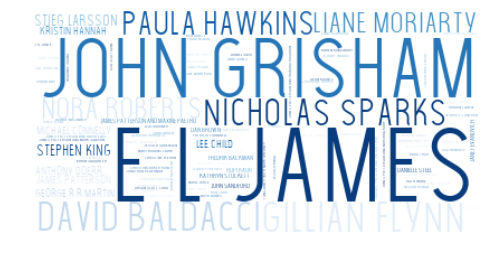

In [16]:
wc = WordCloud(font_path = font_path, background_color="white", max_words=100, 
               max_font_size=90, random_state=100, 
               colormap=matplotlib.cm.Blues)

wc.generate_from_frequencies(num_authappear)

plt.figure(figsize=[8,6])

plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()
wc.to_file("topappearingauthors_wc.png")

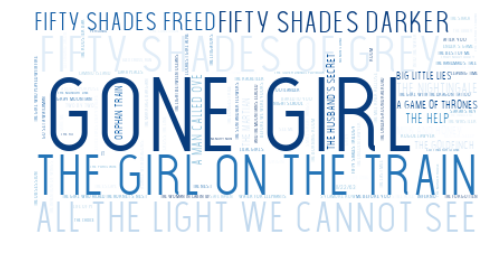

In [17]:
wc = WordCloud(font_path = font_path, background_color="white", max_words=100, 
               max_font_size=90, random_state=100, 
               colormap=matplotlib.cm.Blues)

wc.generate_from_frequencies(num_bookappear2)

plt.figure(figsize=[8,6])

plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()
wc.to_file("topappearingbooks_wc.png")